In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold
import albumentations as A
import cv2

# Format Data

In [2]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

In [3]:
DATA_PATH = '../data/ACDC_dataset/raw_data/training/'
OUT_PATH = '../data/ACDC_dataset/processed_data/'
TABLE_PATH = '../data/split_tables/ACDC/'
os.makedirs(TABLE_PATH,exist_ok=True)

In [4]:
patient_list = [i for i in os.listdir(DATA_PATH) if i.find('cfg')==-1]
n_slices_width = 128
a = np.inf
b = np.inf

In [5]:
for patient in tqdm(patient_list):
    
    files = [i for i in os.listdir(DATA_PATH+patient+'/') if i.find('frame')!=-1 and i.find('gt')==-1]
    
    for index,file in enumerate(files):
        if index == 0:
            img = np.array(nib.load(DATA_PATH+patient+'/'+file).dataobj)
            seg = np.array(nib.load(DATA_PATH+patient+'/'+file[:-7]+'_gt.nii.gz').dataobj)
            
        else:
            temp_img = np.array(nib.load(DATA_PATH+patient+'/'+file).dataobj)
            temp_seg = np.array(nib.load(DATA_PATH+patient+'/'+file[:-7]+'_gt.nii.gz').dataobj)
            img = np.concatenate([img,temp_img],axis=2)
            seg = np.concatenate([seg,temp_seg],axis=2)
    

        
    
    if img.shape[0] > 154:
        x_cut = (img.shape[0]-154)//2
        img = img[x_cut:-1*x_cut,:,:]
        seg = seg[x_cut:-1*x_cut,:,:]
        
    if img.shape[1] > 154:
        y_cut = (img.shape[1]-154)//2
        img = img[:,y_cut:-1*y_cut,:]
        seg = seg[:,y_cut:-1*y_cut,:]
    
    
    img = np.expand_dims(img,axis=0)                  
    seg = np.expand_dims(seg,axis=0)  
    
    
    
    os.makedirs(OUT_PATH+patient,exist_ok=True)
    
 
    
    for i in range(img.shape[-1]):
        temp = img[:,:,:,i]
        temp_y = seg[:,:,:,i]

        
        #save
        np.save(OUT_PATH+patient+f'/{i}_voxels.npy',temp)
        np.save(OUT_PATH+patient+f'/{i}_labels.npy',temp_y)
    


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


# Prepare split tables

In [6]:
patient_list = [OUT_PATH[1:]+i for i in os.listdir(OUT_PATH) if i.find('.')==-1]
print(f'Total number of patients: {len(patient_list)}')

Total number of patients: 100


In [7]:
patient_arr = []
records = []
for patient in patient_list:
    records += [patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1]
    patient_arr += [patient]*len([patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1])
    
records = np.array(records)
patient_arr = np.array(patient_arr)

In [8]:
#create test
kf = GroupKFold(n_splits=5)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break



print(f'Number of unique patients, test subset: {len(np.unique(patient_arr[test]))}')
print(f'Number of samples, test subset: {patient_arr[test].shape[0]}')

patient_arr = patient_arr[train]
records = records[train]

Number of unique patients, test subset: 20
Number of samples, test subset: 382


In [11]:
#create train and validation
n_patients = [2,4,8]

patients_unique = np.unique(patient_arr)

for i in n_patients:
    
    records_temp = records.copy()
    patient_arr_temp = patient_arr.copy()
    
    train_patients = patients_unique[:i]
    train_records = np.empty(0)
    for patient in train_patients.tolist():
        train_records = np.append(train_records,records[patient_arr==patient],axis=0)
        records_temp = records_temp[patient_arr_temp!=patient]
        patient_arr_temp = patient_arr_temp[patient_arr_temp!=patient]
    
    val_patients = patients_unique[-2:]
    val_records = np.empty(0)
    for patient in val_patients.tolist():
        val_records = np.append(val_records,records[patient_arr==patient],axis=0)
#         records_temp = records_temp[patient_arr_temp!=patient]
#         patient_arr_temp = patient_arr_temp[patient_arr_temp!=patient]
    
    
    split = {
            'train': train_records.tolist(),
            'val': val_records.tolist(),
            'pretrain': records_temp.tolist(),
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
            
    print(f'Number of unique patients, train subset: {train_patients.shape[0]}')
    print(f'Number of samples, train subset: {train_records.shape[0]}')
    print(f'Number of unique patients, pretain subset: {len(np.unique(patient_arr_temp))}')
    print(f'Number of samples, pretain subset: {records_temp.shape[0]}')
    print('#######################################################')


    

Number of unique patients, train subset: 2
Number of samples, train subset: 40
Number of unique patients, pretain subset: 78
Number of samples, pretain subset: 1480
#######################################################
Number of unique patients, train subset: 4
Number of samples, train subset: 82
Number of unique patients, pretain subset: 76
Number of samples, pretain subset: 1438
#######################################################
Number of unique patients, train subset: 8
Number of samples, train subset: 162
Number of unique patients, pretain subset: 72
Number of samples, pretain subset: 1358
#######################################################


In [10]:
#create UB

train_patients = patients_unique[patients_unique.shape[0]//5:]
train_records = np.empty(0)
for patient in train_patients.tolist():
    train_records = np.append(train_records,records[patient_arr==patient],axis=0)

val_patients = patients_unique[:patients_unique.shape[0]//5]
val_records = np.empty(0)
for patient in val_patients.tolist():
    val_records = np.append(val_records,records[patient_arr==patient],axis=0)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)

print(f'Number of unique patients, train subset: {train_patients.shape[0]}')
print(f'Number of samples, train subset: {train_records.shape[0]}')
print(f'Number of unique patients, validation subset: {val_patients.shape[0]}')
print(f'Number of samples, validation subset: {val_records.shape[0]}')
print('#######################################################')

Number of unique patients, train subset: 64
Number of samples, train subset: 1206
Number of unique patients, validation subset: 16
Number of samples, validation subset: 314
#######################################################


In [43]:
# add dummpy predictions for semi-supervised folder

split_table = [i for i in os.listdir(TABLE_PATH) if i.find('split_table.json')!=-1]
split_table = split_table[1]

pretrain = json.load(open(TABLE_PATH+split_table))['pretrain']

for train in tqdm(pretrain):
    train = train.replace('voxels','labels')
    train = train.replace("processed_data","semi-supervised")
    path = train[:-len(train.split('/')[-1])]
    os.makedirs('.'+path,exist_ok=True)
    np.save('.'+train,np.zeros((4,n_slices_width,n_slices_width)))

100%|██████████| 1520/1520 [00:11<00:00, 126.73it/s]


# Review augs

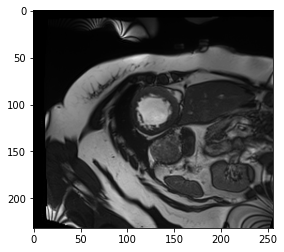

In [148]:
prob = 1
augs = A.Compose(
                [ 
                    A.HorizontalFlip(p=prob),
                    A.VerticalFlip(p=prob),
                    A.Rotate(limit=170, p=prob),
                    A.ElasticTransform(alpha=0.1,p=prob),
                    A.RandomSizedCrop(min_max_height=(120, 120), height=300, width=300, p=prob),
                    A.RandomGamma(gamma_limit=(80, 120), p=prob)
                ]
            )
temp = np.transpose(temp.astype(np.float32), (1, 2, 0))
augmented = augs(image=temp)
temp = np.transpose(temp.astype(np.float32), (2, 0, 1))
image = augmented['image']
image = np.transpose(image.astype(np.float32), (2, 0, 1))

plt.imshow(temp[0],'gray')

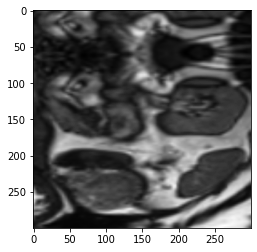

In [149]:
plt.imshow(image[0],'gray')

In [23]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

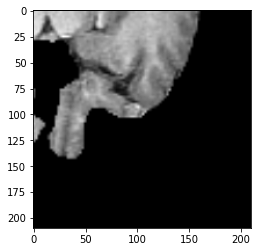

In [24]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')